# Tutorial for get locus specific TRN embedding

ChromBERT represents locus-specific transcriptional regulatory networks (TRNs) using 6391 tensors for humans. Each tensor contains embeddings of specific cistromes, including transcription factors, histone modifications, and chromatin accessibility. Users can obtain embeddings to represent each cistrome, regulator, and locus by using different levels of summarization.  
The basic workflow is as follows:  
- Prepare loci you are interested in.  
- Load the ChromBERT model.  
- Obtain embeddings.  

Let's get started!

In [1]:
import os 
import torch 
import chrombert 
from tqdm import tqdm
import numpy as np
import pandas as pd 
from umap import UMAP

import seaborn as sns
from matplotlib import pyplot as plt

from torchinfo import summary

basedir = "/home/yangdongxu/repos/ChromBERT_reorder/data"


/home/yangdongxu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Prepare dataset
We will use a simple toy dataset for demonstration purposes. Some demo data is provided in the data folder. You can replace it with your own dataset. For more details about the dataset, please refer to the README file.

In [2]:
supervised_file = os.path.join(basedir, "demo","general_classification", "train.csv")
! head {supervised_file}

chrom,start,end,build_region_index,label
chr1,39514000,39515000,34032,1.0
chr9,77647000,77648000,2009188,1.0
chr7,76267000,76268000,1800242,1.0
chr16,154000,155000,690707,1.0
chr11,45252000,45253000,320175,0.0
chr19,58538000,58539000,918112,0.0
chr14,90903000,90904000,613068,0.0
chr14,41607000,41608000,575793,1.0
chr19,41883000,41884000,904333,1.0


In [3]:
dc = chrombert.get_preset_dataset_config("general", basedir=basedir, supervised_file = os.path.join(basedir, "demo","general_classification", "train.csv"))
dc

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


DatasetConfig({'hdf5_file': '/home/yangdongxu/repos/ChromBERT_reorder/data/hg38_6k_1kb.hdf5', 'supervised_file': '/home/yangdongxu/repos/ChromBERT_reorder/data/demo/general_classification/train.csv', 'kind': 'GeneralDataset', 'meta_file': '/home/yangdongxu/repos/ChromBERT_reorder/data/config/hg38_6k_meta.json', 'ignore': False, 'ignore_object': None, 'batch_size': 8, 'num_workers': 20, 'shuffle': False, 'perturbation': False, 'perturbation_object': None, 'perturbation_value': None, 'prompt_kind': None, 'prompt_regulator': None, 'prompt_regulator_cache_file': None, 'prompt_exp_celltype': None, 'prompt_exp_cache_file': None, 'prompt_cistrome_celltype': None, 'prompt_cistrome_celltype_cache_file': None, 'fasta_file': None, 'flank_window': 0})

In [4]:
ds = dc.init_dataset()
dl = dc.init_dataloader(batch_size = 2)
ds[1]

{'input_ids': tensor([9, 7, 6,  ..., 5, 5, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([       9, 77647000, 77648000], dtype=torch.int32),
 'build_region_index': 2009188,
 'label': 1.0}

## Load ChromBERT model
You can either use the pretrained model directly or fine-tune the model with your own data. Below, we demonstrate how to use the pretrained model directly.

In [5]:
mc = chrombert.ChromBERTConfig(
    genome = "hg38",
    ckpt =os.path.join(basedir, "checkpoint", "hg38_6k_1kb_pretrain.ckpt"),
    dropout = 0
)
model = mc.init_model().cuda().bfloat16()
summary(model, depth = 2)

use organisim hg38; sequence length including cls 6392


Layer (type:depth-idx)                             Param #
ChromBERT                                          --
├─BERTEmbedding: 1-1                               --
│    └─TokenEmbedding: 2-1                         7,680
│    └─PositionalEmbedding: 2-2                    4,909,056
│    └─Dropout: 2-3                                --
├─ModuleList: 1-2                                  --
│    └─EncoderTransformerBlock: 2-4                6,497,280
│    └─EncoderTransformerBlock: 2-5                6,497,280
│    └─EncoderTransformerBlock: 2-6                6,497,280
│    └─EncoderTransformerBlock: 2-7                6,497,280
│    └─EncoderTransformerBlock: 2-8                6,497,280
│    └─EncoderTransformerBlock: 2-9                6,497,280
│    └─EncoderTransformerBlock: 2-10               6,497,280
│    └─EncoderTransformerBlock: 2-11               6,497,280
Total params: 56,894,976
Trainable params: 56,894,976
Non-trainable params: 0

In [6]:
for batch in dl:
    emb = model(batch["input_ids"].cuda(), batch["position_ids"].cuda())
    break
emb.shape # embeddings for each cistrome

torch.Size([2, 6391, 768])

## Obtain embeddings
The code above retrieves all the embeddings for the locus. For your convenience, we provide a class to simplify this process. For each batch, you should run a forward pass and then obtain the embeddings for each cistrome, regulator, and locus.

In [7]:
model_emb = chrombert.ChromBERTEmbedding(
    model, mtx_mask= os.path.join(basedir, "config", "hg38_6k_mask_matrix.tsv")
    )
summary(model_emb)

Layer (type:depth-idx)                                  Param #
ChromBERTEmbedding                                      --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

In [8]:
for batch in dl:
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.cuda()
    emb = model_emb(batch)
    break
# by default, it returns all regulator embedding
emb.shape 

torch.Size([2, 1064, 768])

In [9]:
emb = model_emb.get_cistrome_embedding("GSM623516".lower())
emb.shape, emb

(torch.Size([2, 768]),
 tensor([[ 0.3359, -1.6172,  5.3750,  ...,  1.4922, -3.0781,  2.7969],
         [-0.9023, -1.4297,  4.0625,  ...,  1.3750, -3.7188,  3.4844]],
        device='cuda:0', dtype=torch.bfloat16))

In [10]:
emb = model_emb.get_regulator_embedding("ctcf".lower())
emb.shape, emb

(torch.Size([2, 768]),
 tensor([[ 0.0496, -0.7969,  4.4375,  ..., -2.0156, -0.9922,  0.7383],
         [-0.5781, -1.4766,  2.6250,  ..., -1.3828, -0.3848,  0.8906]],
        device='cuda:0', dtype=torch.bfloat16))

In [11]:
emb = model_emb.get_region_embedding()
emb.shape, emb

(torch.Size([2, 768]),
 tensor([[ 0.6992, -0.1250,  2.3906,  ..., -0.8672, -0.4238,  0.7617],
         [-0.2305, -0.6602,  0.9375,  ..., -0.5391,  0.2080,  0.9844]],
        device='cuda:0', dtype=torch.bfloat16))

By the way, using your fine-tuned model to get the embeddings is even easier.

```python
ft_ckpt = None # fill your checkpoint path here
mc = chrombert.get_preset_model_config("general", basedir=basedir, finetune_ckpt=ft_ckpt, dropout = 0)
model = mc.init_model().cuda().bfloat16()
model_emb = model.get_embedding_manager()
model_emb
```
All subsequent steps will be the same as above.


## Example: mean pooled TRN embedding (region embedding)
ChromBERT represents locus-specific TRNs and is useful for finding similarities between cis-elements, such as TF binding sites. Here, we provide an example to get the Mean pooled TRN embedding (region embedding) and demonstrate how ChromBERT can capture the specific features of CTCF binding sites compared to other sites.

Note: Region embeddings derived directly from the pretrained model cannot reflect cell type-specific features. If you want to obtain cell type-specific region embeddings, you can fine-tune the model with your own data. See the fine-tuning tutorial for more details.


In [12]:
from chrombert.scripts.chrombert_make_dataset import get_overlap

df_supervised = get_overlap(
    supervised = os.path.join(basedir, "demo", "embedding","CTCF_ENCFF664UGR.bed"), # a narrowPeak file
    regions = os.path.join(basedir, "config", "hg38_6k_1kb_region.bed"),
    no_filter = True,
).assign(label = lambda df: df["label"] > 0 )
df_supervised

,chrom,start,end,build_region_index,label
0,chr1,10000,11000,0,False
1,chr1,16000,17000,1,False
2,chr1,17000,18000,2,False
3,chr1,29000,30000,3,False
4,chr1,30000,31000,4,False
...,...,...,...,...,...
2137889,chrY,26671000,26672000,2137889,False
2137890,chrY,56674000,56675000,2137890,False
2137891,chrY,56678000,56679000,2137891,False
2137892,chrY,56684000,56685000,2137892,False


In [13]:
# sample down for quick demo
df_sample = df_supervised.query("chrom == 'chr1' ").groupby("label").sample(500, random_state = 1024).reset_index(drop = True)
df_sample.to_csv("supervised_sample.csv", index = False)

df_sample

,chrom,start,end,build_region_index,label
0,chr1,97674000,97675000,81042,False
1,chr1,64197000,64198000,55110,False
2,chr1,77152000,77153000,64764,False
3,chr1,244174000,244175000,180253,False
4,chr1,163181000,163182000,113123,False
...,...,...,...,...,...
995,chr1,16082000,16083000,13121,True
996,chr1,210950000,210951000,152080,True
997,chr1,1165000,1166000,451,True
998,chr1,53278000,53279000,45687,True


In [14]:
dc = chrombert.get_preset_dataset_config("general", basedir=basedir, supervised_file = "supervised_sample.csv")
dl = dc.init_dataloader(batch_size = 2)
ds = dc.init_dataset()
ds[0]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


{'input_ids': tensor([6, 5, 5,  ..., 6, 5, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([       1, 97674000, 97675000], dtype=torch.int32),
 'build_region_index': 81042,
 'label': False}

In [15]:
emb_regions = []
labels = []
# collect region embeddings
with torch.no_grad():
    for batch in tqdm(dl):
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()
        emb = model_emb(batch)
        emb_regions.append(model_emb.get_region_embedding())
        labels.extend(batch["label"].tolist())
labels = np.array(labels)

mtx_emb_regions = torch.cat(emb_regions, dim = 0).detach().float().cpu().numpy()
mtx_emb_regions.shape

100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


(1000, 768)

/home/yangdongxu/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


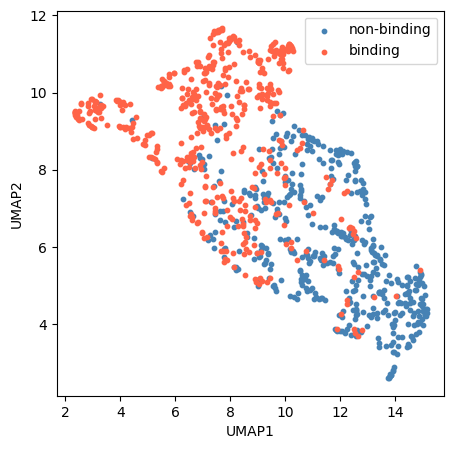

In [16]:
# scatter of umap shows ChromBERT's region embedding distinguishes binding and non-binding regions
mtx_umap = UMAP(n_components = 2, random_state = 1024).fit_transform(mtx_emb_regions)

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(mtx_umap[~labels,0], mtx_umap[~labels,1], c = "steelblue", s = 10, label = "non-binding")
ax.scatter(mtx_umap[labels,0], mtx_umap[labels,1], c = "tomato", s = 10, label = "binding")
ax.legend()
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
plt.show()

In [17]:
!rm supervised_sample.csv # clean environment 

## Example: regulator embedding
Below is an example demonstrating the use of ChromBERT's regulator embedding.

On some specific loci, RNF2 shows similarity with PCGF2, a canonical component of the PRC complex. On other specific loci, RNF2 shows higher similarity with EP300 and MYC, which are related to enhancer activity.

We begin with a processed demo dataset.



In [18]:
supervised_file = os.path.join(basedir, "demo", "embedding", "specific_rnf2_loc_region.csv")
!head {supervised_file}

chrom,start,end,build_region_index
chr1,159925000,159926000,110224
chr1,214297000,214298000,154989
chr1,70354000,70355000,60155
chr1,58783000,58784000,50458
chr1,156501000,156502000,107536
chr1,39770000,39771000,34259
chr1,53195000,53196000,45617
chr1,235083000,235084000,172824
chr1,149608000,149609000,101527


In [19]:
dc = chrombert.get_preset_dataset_config("general", basedir=basedir, supervised_file = supervised_file)
dl = dc.init_dataloader(batch_size = 2)
ds = dc.init_dataset()
ds[0]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.


{'input_ids': tensor([9, 9, 9,  ..., 6, 8, 9], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([        1, 159925000, 159926000], dtype=torch.int32),
 'build_region_index': 110224}

In [20]:
emb_regions = []
list_factors = ["MYC", "EP300", "PCGF2"]
dict_similarities = {i:[] for i in list_factors}

# collect region embeddings
with torch.no_grad():
    for batch in tqdm(dl):
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()
        model_emb(batch)
        emb_rnf2 = model_emb.get_regulator_embedding("rnf2")
        for factor in list_factors:
            emb = model_emb.get_regulator_embedding(factor)
            dict_similarities[factor].append(torch.nn.functional.cosine_similarity(emb_rnf2, emb).float().cpu().numpy())
for factor in dict_similarities:
    dict_similarities[factor] = np.concatenate(dict_similarities[factor])
df_sim = pd.DataFrame(dict_similarities)
df_sim

100%|██████████| 123/123 [00:05<00:00, 21.80it/s]


,MYC,EP300,PCGF2
0,0.777344,0.828125,0.433594
1,0.652344,0.679688,0.351562
2,0.738281,0.832031,0.455078
3,0.664062,0.718750,0.390625
4,0.746094,0.828125,0.427734
...,...,...,...
241,0.204102,0.193359,0.730469
242,0.230469,0.208008,0.824219
243,0.166016,0.279297,0.828125
244,0.201172,0.263672,0.785156


Text(0.5, 1.2, 'Cosine Similarity of RNF2 with Other Regulators')

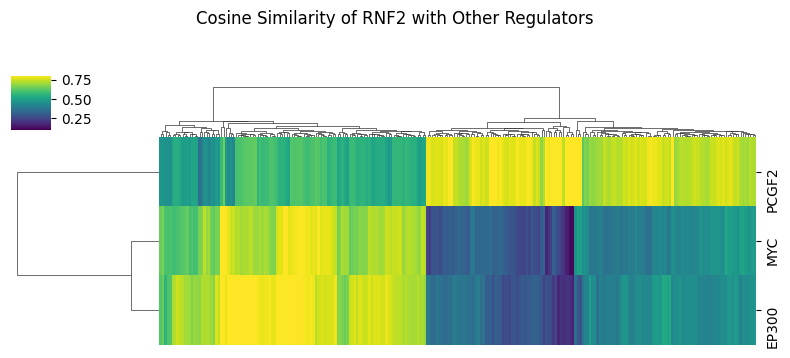

In [21]:
# higher cosine similarity generally indicates stronger relationship
g = sns.clustermap(df_sim.T, figsize=(8,3), xticklabels = False, cmap = "viridis", vmin = 0.1, vmax = 0.8)
g.figure.suptitle("Cosine Similarity of RNF2 with Other Regulators",y=1.2)

## The end
That's nearly all!  
For models tuned for gene expression prediction tasks or similar tasks, it involves pooling several regions to obtain the final embedding. We provided unified functions to do that, but for more details, please refer to the related tutorial file.